In [1]:
import pandas as pd
import scipy
import numpy as np
import h5py

from constants import HARD_WIRED_GENOME_A_MATRIX_PATH, STRING_EXTRACTED_URL_PATH, STRING_PROTEIN_GENE_PATH, DATA_DIRECTORY, HURI_UNIQUE_GENE_SET
from mapping import get_unique_genes, generate_unique_gene_set_Huri

In [2]:
import matplotlib.pyplot as plt

import scanpy as sc
import networkx as nx

from scipy.linalg import eigvalsh

from anndata import AnnData

In [3]:
from mapping import get_string_protein_gene_map, generate_string_mappings, generate_unique_gene_set_Huri, get_unique_genes, construct_HardWiredGenome_A_Matrix, construct_HardWiredGenome_B_Matrix

In [3]:
# Counting number of unique proteins from STRING

with open(STRING_EXTRACTED_URL_PATH, "r") as stringfile:
    lines = stringfile.readlines()
    proteinset = set()
    for line in lines:
        p1, p2, score = line.strip().split()
        proteinset.add(p1)
        proteinset.add(p1)
    print(f"Number of Unique Proteins in STRING: {len(proteinset)}")
    

Number of Unique Proteins in STRING: 19623


In [4]:
# Counting unique Genes

genelist = get_unique_genes()

huri_genes = generate_unique_gene_set_Huri()

['ENSG00000172046', 'ENSG00000146215', 'ENSG00000221821', 'ENSG00000196184', 'ENSG00000064601', 'ENSG00000157445', 'ENSG00000196912', 'ENSG00000103528', 'ENSG00000167552', 'ENSG00000077454']
['ENSG00000160563', 'ENSG00000145103', 'ENSG00000164707', 'ENSG00000155034', 'ENSG00000188483'] 19621
Unique genes from STRING: 19621
Unique genes from HURI: 11603
Total unique genes: 19677
Unique Genes from HI-Union: 9094
Unique Genes from LIT-BM: 6047
Total unique genes HURI ( union of HI-Union + LIT-BM ): 11603


In [4]:
string_proteinset = generate_string_mappings()

KeyboardInterrupt: 

In [5]:
len(string_proteinset)

NameError: name 'string_proteinset' is not defined

In [9]:
with open(STRING_PROTEIN_GENE_PATH, "r") as f:
    protein_gene_map = f.readlines()


['9606.ENSP00000240364',
 '9606.ENSP00000401197',
 '9606.ENSP00000361650',
 '9606.ENSP00000386146',
 '9606.ENSP00000492902',
 '9606.ENSP00000361562',
 '9606.ENSP00000419101',
 '9606.ENSP00000481149',
 '9606.ENSP00000347538',
 '9606.ENSP00000439020']

In [21]:
string_gene_set = set()
non_existent_proteins = set()

for protein in list(string_proteinset):
    splitprotein = protein.split(".")
    if len(splitprotein) > 1:
        protid = splitprotein[1]
    else:
        non_existent_proteins.add(protein)
    geneid = string_protein_gene_map.get(protid, None)
    if geneid is not None:
        string_gene_set.add(geneid)
    else:
        non_existent_proteins.add(pid)

In [106]:
string_protein_gene_map = get_string_protein_gene_map()

In [107]:
unique_gene_set_huri = generate_unique_gene_set_Huri()

Unique Genes from HI-Union: 9094
Unique Genes from LIT-BM: 6047
Total unique genes HURI ( union of HI-Union + LIT-BM ): 11603


In [7]:
total_unique_genes = unique_gene_set_huri.union(string_gene_set)
len(total_unique_genes)

NameError: name 'string_gene_set' is not defined

In [105]:
len(string_protein_gene_map.keys())

filtered_string_protein_gene_map = {key: value for key, value in string_protein_gene_map.items() if value in nodes}
print(len(filtered_string_protein_gene_map.keys()))

NameError: name 'string_protein_gene_map' is not defined

In [6]:
unique_genes = get_unique_genes()
filtered_gene_metadata = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/operations/filtered_gene_metadata.csv')

nodes = list(filtered_gene_metadata.GeneStableID)

['ENSG00000172046', 'ENSG00000146215', 'ENSG00000221821', 'ENSG00000196184', 'ENSG00000064601', 'ENSG00000157445', 'ENSG00000196912', 'ENSG00000103528', 'ENSG00000167552', 'ENSG00000077454']
['ENSG00000160563', 'ENSG00000145103', 'ENSG00000164707', 'ENSG00000155034', 'ENSG00000188483'] 19621
Unique genes from STRING: 19621
Unique genes from HURI: 11603
Total unique genes: 19677


In [5]:

HARD_WIRED_GENOME_A_EDGELIST = f"{DATA_DIRECTORY}/HWG/A_Matrix_edgelist.csv"
HARD_WIRED_GENOME_B_EDGELIST = f"{DATA_DIRECTORY}/HWG/B_Matrix_edgelist.csv"

In [234]:
import os
from constants import HWG_BASE_PATH, HI_UNION_PATH, LIT_BM_PATH, ENSEMBL_PROTEIN_GENE_PATH
def construct_HardWiredGenome_A_Matrix(threshold=600, nodes=None):
    """
    Construct the full A matrix of the Hard Wired Genome from the STRING and HURI datasets
    """
    if not os.path.exists(HWG_BASE_PATH):
        os.makedirs(HWG_BASE_PATH)
    print("Constructing Hard Wired Genome A Matrix")

    if nodes is None:
        nodes = get_unique_genes()

    # with open(ENSEMBL_PROTEIN_GENE_PATH, "r") as protein_gene_file:
    #     protein_gene_map = {}
    #     for line in protein_gene_file:
    #         gene, protein = line.split()
    #         protein_gene_map[protein] = gene

    string_protein_gene_map = get_string_protein_gene_map()

    n = len(nodes)

    node_idx = {g: i for i, g in enumerate(nodes)}
    adj = np.zeros((len(nodes), len(nodes)), dtype=int)

    # adj_df = pd.DataFrame(0, index=nodes, columns=nodes)

    # initialize edge set
    edges = set()
    count = 0

    with open(STRING_EXTRACTED_URL_PATH, "r") as f: 
        string_links = f.readlines()

        # skipping header line
        for link in string_links[1:]:
            count += 1
            p1, p2, score = link.strip().split(' ')
            p1 = p1.split('.')[1]
            p2 = p2.split('.')[1]
            score = int(score)
            g1 = string_protein_gene_map.get(p1, None)
            g2 = string_protein_gene_map.get(p2, None)
            # if score >= threshold:
            
            # if g1 in nodes and g2 in nodes:
            if g1 is not None and g2 is not None and score >= threshold:
                edges.add((g1, g2, 1))
    print("STRING interactions processed: ", len(edges))


    with open(HI_UNION_PATH, "r") as huri_links:
        for link in huri_links:
            g1, g2 = link.strip().split()
            edges.add((g1, g2, 1))
    print("HI-UNION interactions processed: ", len(edges))

    with open(LIT_BM_PATH, "r") as lit_links:
        for link in lit_links:
            g1, g2 = link.strip().split()
            edges.add((g1, g2, 1))
    print("LIT-BM interactions processed: ", len(edges))
    
    # for g1, g2, inter in edges:
    #     if g1 in node_idx and g2 in node_idx:
    #         i, j = node_idx[g1], node_idx[g2]
    #         adj[i, j] = 1
    import pandas as pd

    edgelist = list(edges)
    edgelist_df = pd.DataFrame(edgelist, columns=['source', 'target', 'weight'])

    
    # adj_df = pd.DataFrame(adj, index=nodes, columns=nodes)

    save_path = HARD_WIRED_GENOME_A_EDGELIST.strip('.csv') + f"_{threshold}.csv"
    edgelist_df.to_csv(save_path)

    print(f"Saved Hard Wired Genome to {save_path}")

In [235]:
# Constructing the A matrix

# No threshold
# 12549752

# 600 threshold
# 662226

# 150 threshold



# A_matrix = construct_HardWiredGenome_A_Matrix(threshold=600, nodes=nodes)
# A_matrix_150 = construct_HardWiredGenome_A_Matrix(threshold=150, nodes=nodes)
A_matrix_300 = construct_HardWiredGenome_A_Matrix(threshold=300, nodes=nodes)

Constructing Hard Wired Genome A Matrix
STRING interactions processed:  3399008
HI-UNION interactions processed:  3455002
LIT-BM interactions processed:  3457994
Saved Hard Wired Genome to /Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/A_Matrix_edgelist_300.csv


In [6]:
threshold = 300
# path = HARD_WIRED_GENOME_A_MATRIX_PATH.strip('.csv') + f"_{threshold}.csv"

path =  HARD_WIRED_GENOME_A_EDGELIST.strip('.csv') + f"_{threshold}.csv"

A_matrix_edgelist = pd.read_csv(path, index_col=0)

In [19]:
filtered_A_matrix_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(flat_col_order) & A_matrix_edgelist['target'].isin(flat_col_order)
]

fil_path =  HARD_WIRED_GENOME_A_EDGELIST.strip('.csv') + f"filetered_{threshold}.csv"

filtered_A_matrix_edgelist.to_csv(fil_path, index=False)

In [16]:
np_arr = A_matrix.to_numpy()

In [18]:
df = A_matrix.copy()

df = df.clip(lower=0, upper=np.iinfo(np.uint32).max).astype(np.uint32)

# df = df.astype(np.int64)
mat_dict = {
    'data': df.to_numpy(),
    'columns': df.columns.to_list()
}
scipy.io.savemat('/scratch/indikar_root/indikar1/shared_data/HWG/operations/A_matrix.mat', mat_dict)

In [59]:
# mat = scipy.io.loadmat('/scratch/indikar_root/indikar1/shared_data/HWG/operations/DSET038-37_Combined_GRCh38p14_GRCh37p13_EnsemblBioMart_allGenes.mat')
gene_metadata = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/operations/DSET038_37_Combined_GRCh38p14_GRCh37p13.txt')

# print(gene_metadata.head)
filtered_gene_metadata = gene_metadata[gene_metadata['GeneType'] == 'protein_coding']

chromosome_list = [str(i) for i in range(23)]
filtered_gene_metadata = filtered_gene_metadata[filtered_gene_metadata['ChromosomescaffoldName'].isin(chromosome_list)]

filtered_gene_metadata = filtered_gene_metadata[filtered_gene_metadata['GeneStableID'].isin(list(nodes))]
filtered_gene_metadata = filtered_gene_metadata[filtered_gene_metadata['ReferenceGenome'] == 'GRCh38.p14']

filtered_gene_metadata = filtered_gene_metadata[['GeneStableID', 'ChromosomescaffoldName']].drop_duplicates()

print(filtered_gene_metadata.head)

len(filtered_gene_metadata)

<bound method NDFrame.head of           GeneStableID ChromosomescaffoldName
2      ENSG00000000419                     20
3      ENSG00000000457                      1
4      ENSG00000000460                      1
5      ENSG00000000938                      1
6      ENSG00000000971                      1
...                ...                    ...
64717  ENSG00000287542                      4
65005  ENSG00000287856                      1
65138  ENSG00000288000                     20
65627  ENSG00000288520                      6
65658  ENSG00000288558                      7

[18581 rows x 2 columns]>


18581

In [60]:
filtered_gene_metadata.to_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/operations/filtered_gene_metadata.csv', index=False)

In [11]:
from constants import HARD_WIRED_GENOME_A_MATRIX_PATH

A_matrix = pd.read_csv(HARD_WIRED_GENOME_A_MATRIX_PATH, index_col = 0)

In [41]:
headers = A_matrix.columns.tolist()

In [7]:
filtered_gene_metadata = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/operations/filtered_gene_metadata.csv')
group_dict = filtered_gene_metadata.groupby('ChromosomescaffoldName')['GeneStableID'].apply(list).to_dict()

sorted_groups = dict(sorted(group_dict.items()))
flat_col_order = [col for group in sorted_groups.values() for col in group]

len(flat_col_order)

18581

In [64]:
# df_sorted = A_matrix[flat_col_order, flat_col_order]

df_sorted = A_matrix.loc[flat_col_order, flat_col_order]
# sorted_groups = sorted([ int(i) for i in group_dict.keys()])

ch19 = df_sorted.loc[sorted_groups[19], sorted_groups[19]]
ch22 = df_sorted.loc[sorted_groups[22], sorted_groups[22]]

chromosomes = [19, 20, 21, 22]
keys = []
for chromosome in chromosomes:
    keys.extend(sorted_groups[chromosome])
print(keys)

ch19_22 = df_sorted.loc[keys, keys]

['ENSG00000004776', 'ENSG00000004777', 'ENSG00000005007', 'ENSG00000005206', 'ENSG00000006015', 'ENSG00000006016', 'ENSG00000006638', 'ENSG00000006659', 'ENSG00000006712', 'ENSG00000007047', 'ENSG00000007080', 'ENSG00000007129', 'ENSG00000007255', 'ENSG00000007264', 'ENSG00000007306', 'ENSG00000008382', 'ENSG00000008438', 'ENSG00000008441', 'ENSG00000010310', 'ENSG00000010361', 'ENSG00000011132', 'ENSG00000011243', 'ENSG00000011304', 'ENSG00000011332', 'ENSG00000011422', 'ENSG00000011451', 'ENSG00000011478', 'ENSG00000011485', 'ENSG00000011590', 'ENSG00000011600', 'ENSG00000012061', 'ENSG00000012124', 'ENSG00000013275', 'ENSG00000018869', 'ENSG00000021488', 'ENSG00000022556', 'ENSG00000024422', 'ENSG00000028277', 'ENSG00000031823', 'ENSG00000032444', 'ENSG00000037757', 'ENSG00000039650', 'ENSG00000039987', 'ENSG00000042753', 'ENSG00000051128', 'ENSG00000053501', 'ENSG00000060558', 'ENSG00000060566', 'ENSG00000062370', 'ENSG00000062822', 'ENSG00000063127', 'ENSG00000063169', 'ENSG000000

In [70]:
edges = []

for source in ch19_22.index:
    for target in ch19_22.columns:
        weight = ch19_22.loc[source, target]
        if weight != 0:
            edges.append({'Source': source, 'Target': target, 'Weight': weight})

edge_df = pd.DataFrame(edges)

edge_df.to_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/operations/HWG_chr19_22_edgelist.csv', index=False)

In [59]:
ch19_22.to_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/operations/HWG_chr19_22.csv')

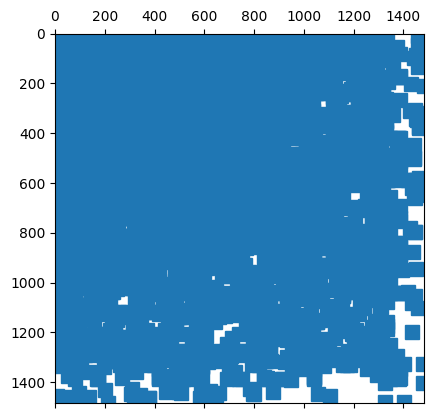

In [ ]:
from scipy.sparse import csr_matrix

sparse_adj = csr_matrix(ch19_22.values)
plt.spy(sparse_adj)
plt.show()

# Block averaging to downsample matrix to something like 500x500
# def block_mean(arr, factor):
#     return arr.reshape(
#         arr.shape[0] // factor, factor,
#         arr.shape[1] // factor, factor
#     ).mean(axis=(1, 3))

# downsample_factor = 40  # 20000 / 500
# matrix = df.values
# small_matrix = block_mean(df_sorted, downsample_factor)


In [67]:
ch19_22

,ENSG00000004776,ENSG00000004777,ENSG00000005007,ENSG00000005206,ENSG00000006015,ENSG00000006016,ENSG00000006638,ENSG00000006659,ENSG00000006712,ENSG00000007047,...,ENSG00000278195,ENSG00000278558,ENSG00000283809,ENSG00000283900,ENSG00000284194,ENSG00000284554,ENSG00000285025,ENSG00000285304,ENSG00000285404,ENSG00000286070
ENSG00000004776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000004777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000005007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000005206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000006015,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000285025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000285304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000285404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


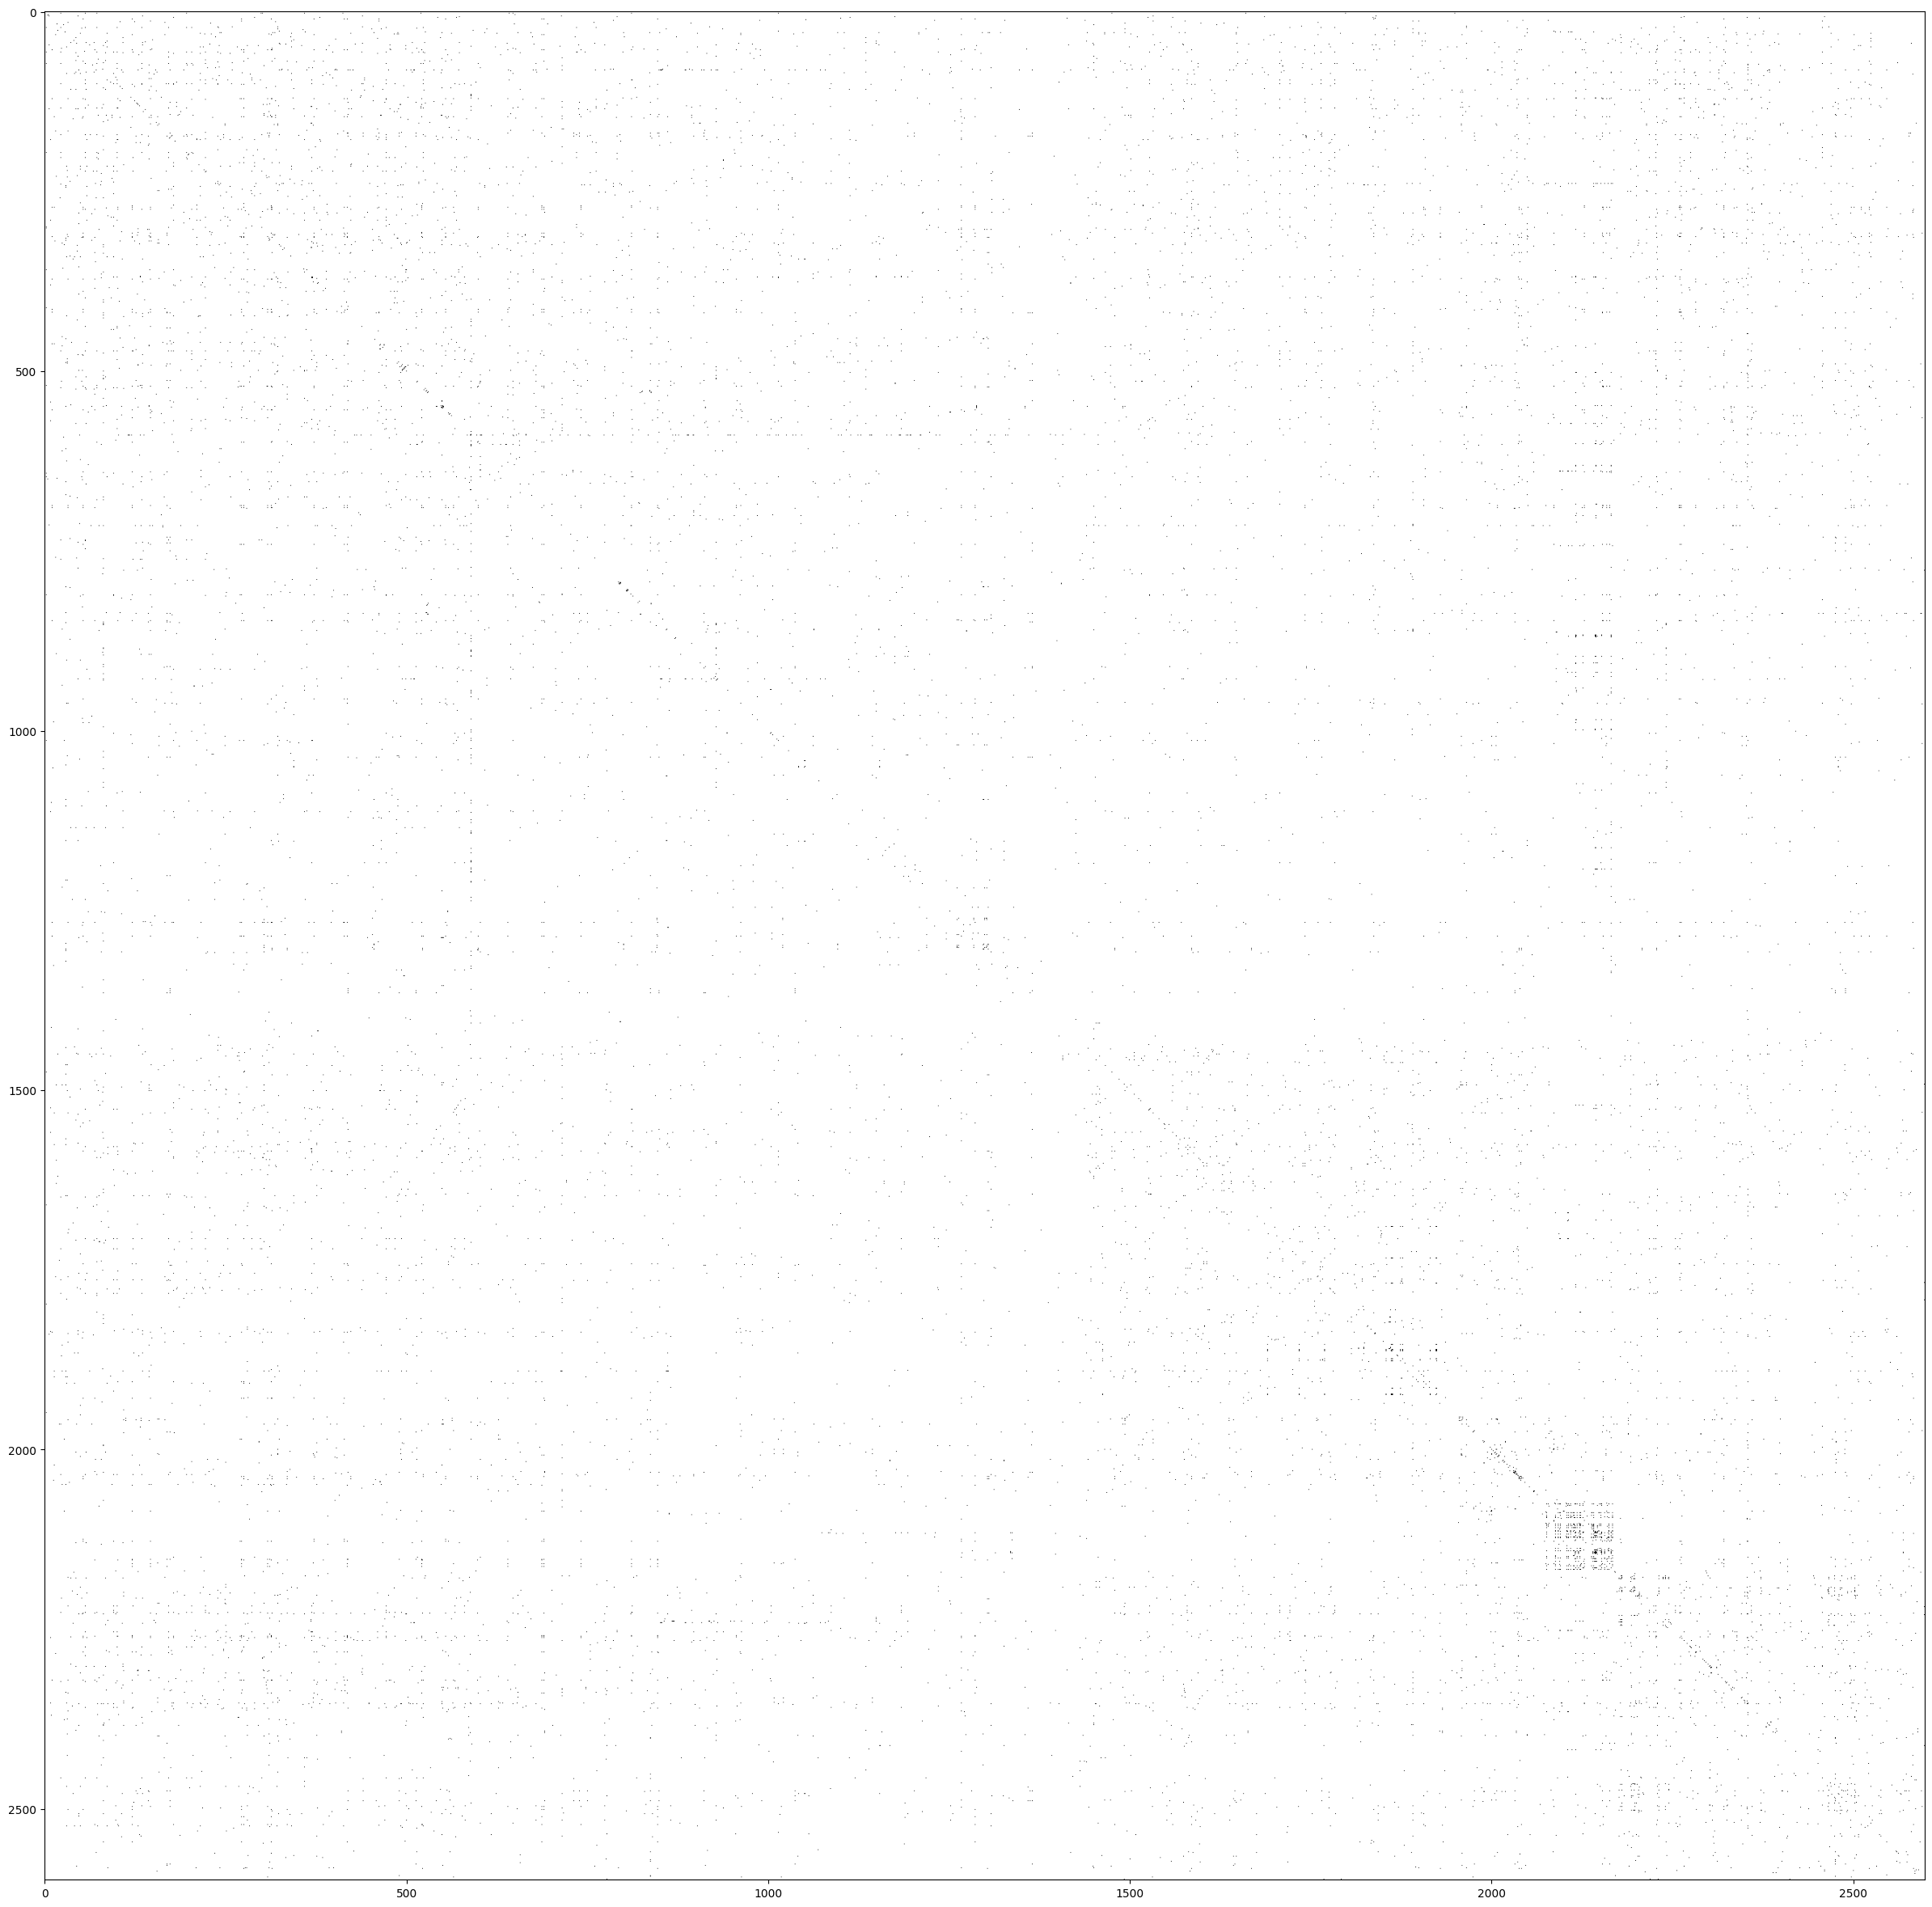

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
plt.imshow(ch19_22.values, cmap='binary', aspect='auto')
# plt.colorbar(label='Value')
plt.show()

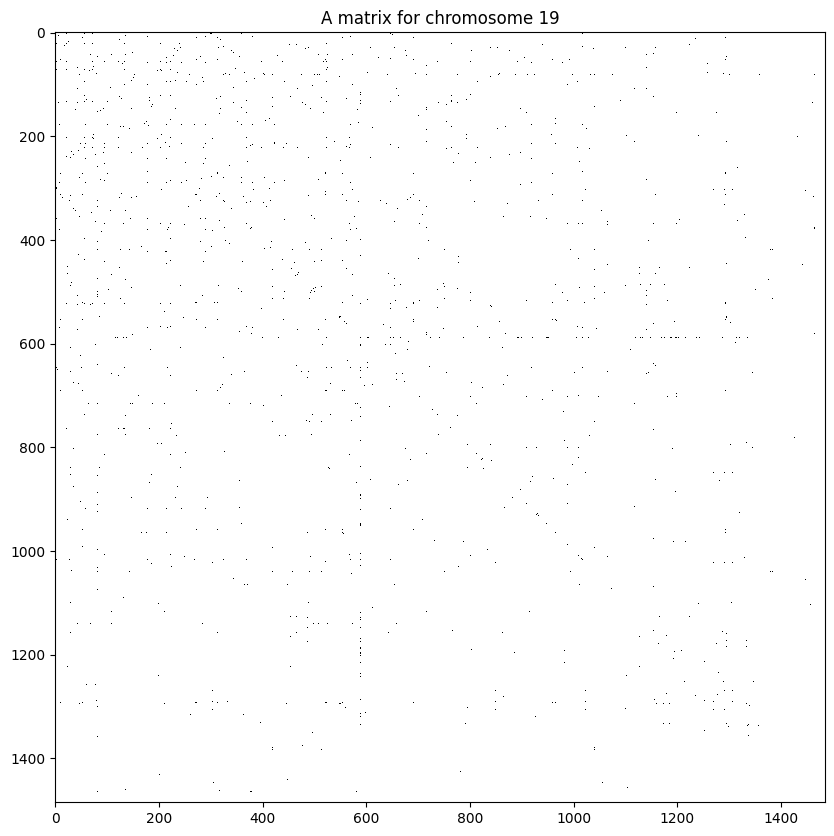

In [68]:
# masked = np.ma.masked_where(ch19 == 0, ch19)

plt.figure(figsize=(10, 10))

from matplotlib.colors import ListedColormap

ch19val = ch19.values[:300,:300]
cmap = ListedColormap(['black', 'blue'])
plt.imshow(ch19, cmap='binary', interpolation='nearest')
plt.title("A matrix for chromosome 19")
# plt.imshow(ch19.values, cmap='binary', aspect='auto')
# plt.colorbar(label='Value')
plt.savefig('chr19_A_matrix_sub.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)

In [ ]:
plt.xticks(ticks=np.arange(len(flat_col_order)), labels=flat_col_order, rotation=90)
plt.yticks(ticks=np.arange(df_sorted.shape[0]))

col_index = 0
for group_cols in sorted_groups.values():
    col_index += len(group_cols)
    if col_index < len(flat_col_order):
        plt.axvline(x=col_index - 0.5, color='white', linestyle='--', linewidth=2)

plt.title("Matrix with Group Boundaries")
plt.tight_layout()
plt.show()

In [36]:
# Block averaging to downsample matrix to something like 500x500
def block_mean(arr, factor):
    return arr.reshape(
        arr.shape[0] // factor, factor,
        arr.shape[1] // factor, factor
    ).mean(axis=(1, 3))


downsample_factor = 40  # 20000 / 500
matrix = df_sorted.values
small_matrix = block_mean(matrix[:20000, :20000], downsample_factor)


plt.figure(figsize=(12, 10))
plt.imshow(small_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Expression')
plt.title("Gene-Gene interaction Matrix")
plt.tight_layout()
plt.show()

group_size = 1000
factor = downsample_factor
for i in range(group_size // factor, small_matrix.shape[0], group_size // factor):
    plt.axhline(i - 0.5, color='white', linestyle='--', linewidth=1)
    plt.axvline(i - 0.5, color='white', linestyle='--', linewidth=1)


ValueError: cannot reshape array of size 370986121 into shape (481,40,481,40)

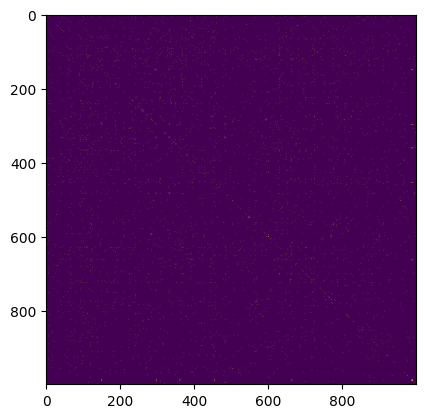

In [32]:
plt.figure()
plt.imshow(df_sorted.values[:1000, :1000])
plt.show()

In [71]:
from constants import STRING_UNIQUE_GENE_SET


geneset = set()
proteinset = set()
with open(STRING_UNIQUE_GENE_SET, 'r') as f:
    lines = f.readlines()
    for line in lines:
        geneset.add(line.strip())
        

In [72]:
len(geneset)

19699

In [ ]:
from mapping import generate_protein_gene_mapping_STRING

generate_protein_gene_mapping_STRING()

In [3]:
from constants import STRING_PROTEIN_GENE_PATH

protein_unique = set()
gene_unique = set()
with open(STRING_PROTEIN_GENE_PATH, 'r') as f:
    lines = f.readlines()
    for line in lines:
        p, g = line.strip().split()
        protein_unique.add(p)
        gene_unique.add(g)

In [116]:

mat_file = h5py.File('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/RNAseq/RNAseq Vectors 2015-2024.mat', 'r')
print(mat_file)

<HDF5 file "RNAseq Vectors 2015-2024.mat" (mode r)>


In [11]:
X = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/RNAseq/X.csv')
X_arr = X.to_numpy()
obs = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/RNAseq/obs.csv', index_col=0)
var = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/RNAseq/var.csv', index_col=0)

In [52]:
from scipy.stats import wasserstein_distance
from scipy.stats import entropy
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
from scipy.sparse import linalg as spla
import networkx as nx


def print_important_info(stat_array):
    print("Shape:", stat_array.shape)
    print("Data type:", stat_array.dtype)
    print("min", stat_array.min())
    print("max", stat_array.max())
    print("First 5 elements:", stat_array.flatten()[:5])
    print("Last 5 elements:", stat_array.flatten()[-5:])
    nzarr = np.nonzero(stat_array)
    print("Non zero elements:", np.count_nonzero(nzarr))
    plt.figure(figsize=(10, 6))
    plt.hist(stat_array, bins=20) # Create a histogram with 20 bins


def calculate_network_stats_between_network(network1, network2):
    edgelist1 = nx.to_pandas_edgelist(network1)
    edgelist2 = nx.to_pandas_edgelist(network2)
    edges1 = set(map(tuple, edgelist1[['source', 'target']].values))
    edges2 = set(map(tuple, edgelist2[['source', 'target']].values))

    intersection = len(edges1 & edges2)
    union = len(edges1 | edges2)

    intersection = len(edges1 & edges2)
    union = len(edges1 | edges2)

    jaccard_distance = 1 - intersection / union
    print(f"Jaccard Distance: {jaccard_distance:.4f}")

    L1 = nx.normalized_laplacian_matrix(G1).toarray()
    L2 = nx.normalized_laplacian_matrix(G2).toarray()

    # Compute eigenvalues
    eig1 = eigvalsh(L1)
    eig2 = eigvalsh(L2)

    # Pad shorter eigenvector if needed
    min_len = min(len(eig1), len(eig2))
    spectral_dist = np.linalg.norm(eig1[:min_len] - eig2[:min_len])
    print(f"Spectral Distance: {spectral_dist}")

    deg1 = np.array([d for n, d in network1.degree()])
    deg2 = np.array([d for n, d in network2.degree()])

    dist = wasserstein_distance(deg1, deg2)

def calculate_network_stats(G):

    n = G.number_of_nodes()
    m = G.number_of_edges()

    # For undirected graphs: total possible edges = n*(n-1)/2
    total_possible_edges = n * (n - 1) / 2 if not G.is_directed() else n * (n - 1)
    sparsity = 1 - (m / total_possible_edges)

    print(f"Sparsity: {sparsity:.4f}")


    A = nx.to_scipy_sparse_array(G, format='csr')

    A = csr_matrix(A)
    # Compute top eigenvalue using sparse matrix method (fast)
    eigenvalue = spla.eigsh(A.asfptype(), k=1, which='LA', return_eigenvectors=False)[0]

    print(f"Top Eigenvalue: {eigenvalue:.4f}")


    degrees = np.array([deg for _, deg in G.degree()])
    degree_counts = np.bincount(degrees)
    degree_prob = degree_counts / degree_counts.sum()

    shannon_entropy = entropy(degree_prob, base=2)
    print(f"Network Entropy (degree distribution): {shannon_entropy:.4f}")


    L = nx.normalized_laplacian_matrix(G).toarray()

    # Compute eigenvalues
    eigvals = eigh(L, eigvals_only=True)

    # Normalize to sum to 1 for entropy
    eigvals = eigvals[eigvals > 0]  # remove 0s
    eigvals /= eigvals.sum()

    vn_entropy = -np.sum(eigvals * np.log2(eigvals))
    print(f"Von Neumann Entropy: {vn_entropy:.4f}")




In [12]:
fibroblast_expression = X_arr[7]
fibroblast_expression = np.nan_to_num(fibroblast_expression, nan=0)
esc_expression = X_arr[11]
esc_expression = np.nan_to_num(esc_expression, nan=0)
myotube_expression = X_arr[12]
myotube_expression = np.nan_to_num(myotube_expression, nan=0)

fibroblast_nz_indices = np.nonzero(fibroblast_expression)
esc_nz_indices = np.nonzero(esc_expression)
myotube_nz_indices = np.nonzero(myotube_expression)

Shape: (22083,)
Data type: float64
min 0.0
max 115344.475
First 5 elements: [7.69939667e+00 1.68580458e+00 9.69890167e-03 6.62899375e+01
 5.85606208e-01]
Last 5 elements: [  0.32968008   8.362975   206.496125     7.58528833  12.0230875 ]
Non zero elements: 19345
-----------------
Shape: (22083,)
Data type: float64
min 0.0
max 2502.2874
First 5 elements: [ 0.        0.        2.839243 15.113856  0.      ]
Last 5 elements: [  9.9767  128.3976   48.94578 204.1038  232.8114 ]
Non zero elements: 13991
-----------------
Shape: (22083,)
Data type: float64
min 0.0
max 1742.7119
First 5 elements: [ 0.        0.        0.       71.702484  0.      ]
Last 5 elements: [ 11.5005   92.1894   27.05513 163.9425  197.396  ]
Non zero elements: 12016


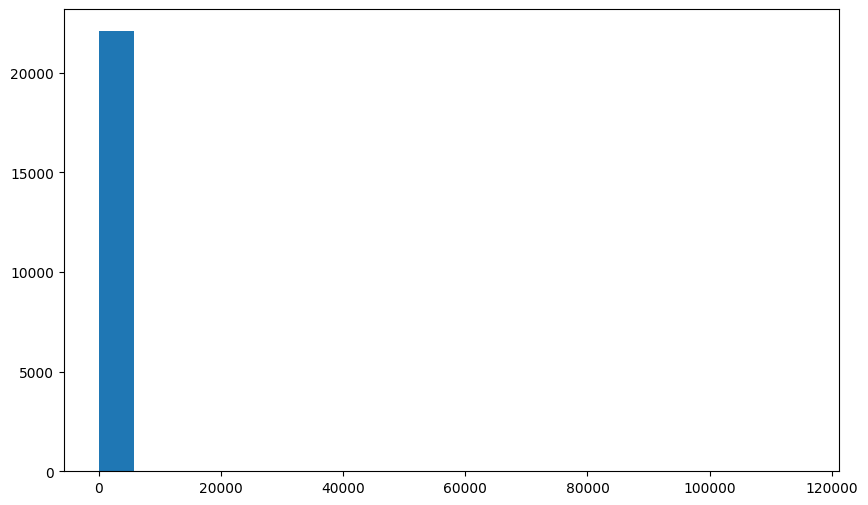

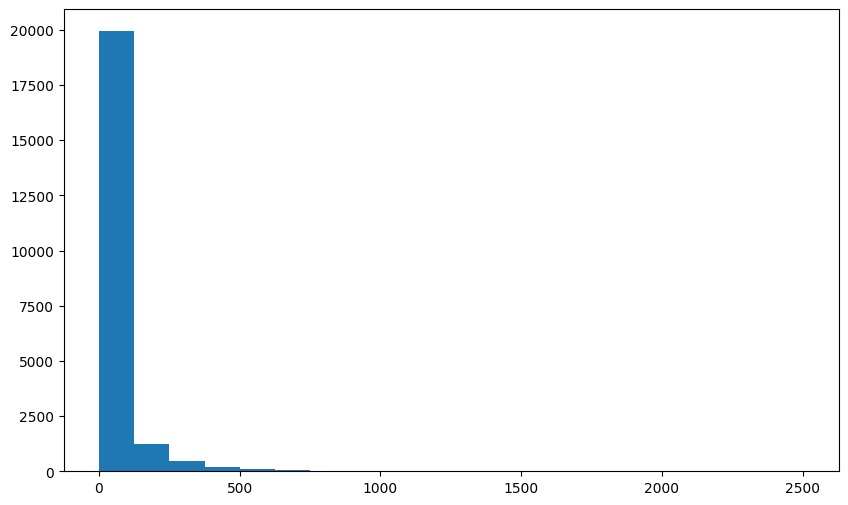

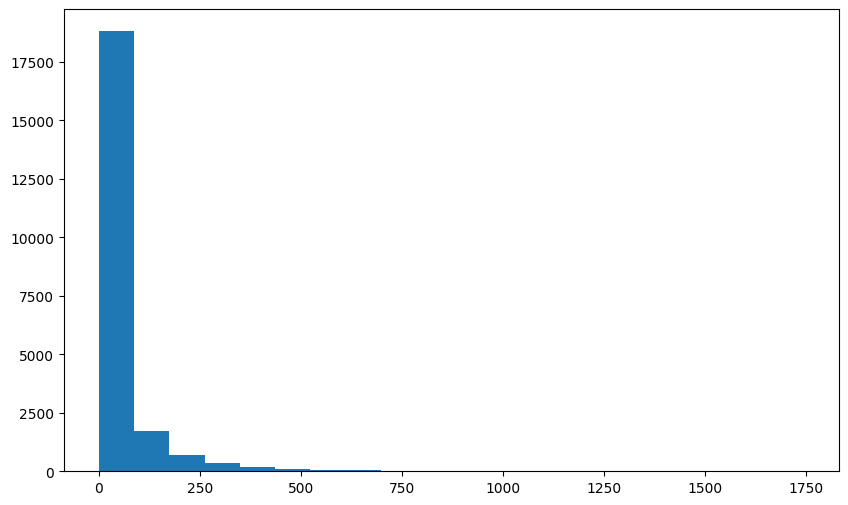

In [25]:
print_important_info(fibroblast_expression)
print("-----------------")
print_important_info(esc_expression)
print("-----------------")
print_important_info(myotube_expression)



/Users/ramprakash/miniconda3/envs/HardWiredGenome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
samples = ['Fibroblast', 'EmbryonicStemCells', 'Myotube']
X = np.vstack([fibroblast_expression, esc_expression, myotube_expression])

adata = AnnData(X=X)

adata.var_names = var.GeneStableID        # columns (genes)
adata.obs_names = samples

In [38]:
adata_bk = adata.copy()

/Users/ramprakash/miniconda3/envs/HardWiredGenome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/ramprakash/miniconda3/envs/HardWiredGenome/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [42]:
gene_names = adata.var_names
cell_names = adata.obs_names

gen_threshold = 0.2

X_dense = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X


expressed_genes_per_cell = []

for i, row in enumerate(X_dense):
    expressed = gene_names[row > gen_threshold]
    expressed_genes_per_cell.append(list(expressed))

# Optional: convert to DataFrame for easier inspection
df = pd.DataFrame({
    'cell': cell_names,
    'expressed_genes': expressed_genes_per_cell
})


In [43]:
print(len(df.iloc[0].expressed_genes))
print(len(df.iloc[1].expressed_genes))
print(len(df.iloc[2].expressed_genes))

fibroblast_expressed_genes = df.iloc[0].expressed_genes
esc_expressed_genes = df.iloc[1].expressed_genes
myotube_expressed_genes = df.iloc[2].expressed_genes

5006
7018
7478


In [44]:
A_matrix_edgelist = filtered_A_matrix_edgelist

In [45]:
# fibroblast_expressed_genes
# myotube_expressed_genes
# esc_expressed_genes

fibroblast_filtered_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(fibroblast_expressed_genes) & A_matrix_edgelist['target'].isin(fibroblast_expressed_genes)
]
myotube_filtered_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(myotube_expressed_genes) & A_matrix_edgelist['target'].isin(myotube_expressed_genes)
]
esc_filtered_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(esc_expressed_genes) & A_matrix_edgelist['target'].isin(esc_expressed_genes)
]


In [46]:
celltype = 'Fibroblast'
threshold = 150
gen_threshold = 0.6

# path = HARD_WIRED_GENOME_A_MATRIX_PATH.strip('.csv') + f"_{threshold}.csv"

path =  HARD_WIRED_GENOME_A_EDGELIST.strip('.csv') + f"_{threshold}_{celltype}_{gen_threshold}.csv"

# fibroblast_filtered_edgelist.to_csv(path, index=False)
fibroblast_filtered_edgelist = pd.read_csv(path)



In [47]:

celltype = 'Myotube'
threshold = 150
gen_threshold = 0.6

path =  HARD_WIRED_GENOME_A_EDGELIST.strip('.csv') + f"_{threshold}_{celltype}_{gen_threshold}.csv"

# df = pd.read_csv(path, index_col=0)
# myotube_filtered_edgelist.to_csv(path, index=False)

myotube_filtered_edgelist = pd.read_csv(path)


In [48]:

celltype = 'EmbryonicStemCells'
threshold = 150
gen_threshold = 0.6

path =  HARD_WIRED_GENOME_A_EDGELIST.strip('.csv') + f"_{threshold}_{celltype}_{gen_threshold}.csv"

# df = pd.read_csv(path, index_col=0)
# esc_filtered_edgelist.to_csv(path, index=False)

esc_filtered_edgelist = pd.read_csv(path)


In [49]:
print(len(fibroblast_filtered_edgelist))
print(len(myotube_filtered_edgelist))
print(len(esc_filtered_edgelist))

312563
824868
2993076


In [50]:
unique_genes = pd.unique(A_matrix_edgelist[['source', 'target']].values.ravel())

In [51]:
len(unique_genes)

18537

In [52]:
unique_genes_count = len(flat_col_order)
unique_genes_count

18581

In [53]:
total_blocks = unique_genes_count * unique_genes_count

In [54]:
fibroblast_G = nx.from_pandas_edgelist(fibroblast_filtered_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())
myotube_G = nx.from_pandas_edgelist(myotube_filtered_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())
esc_G = nx.from_pandas_edgelist(esc_filtered_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())

In [55]:
fibroblast_G.add_nodes_from(flat_col_order)
myotube_G.add_nodes_from(flat_col_order)
esc_G.add_nodes_from(flat_col_order)

In [222]:
def get_graph_info(graph):
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    is_connected = nx.is_connected(graph)

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Graph is connected: {is_connected}")


In [138]:
get_graph_info(fibroblast_G)
get_graph_info(myotube_G)
get_graph_info(esc_G)

Number of nodes: 18581
Number of edges: 1008423
Graph is connected: False
Number of nodes: 18582
Number of edges: 1499254
Graph is connected: False
Number of nodes: 18582
Number of edges: 1499254
Graph is connected: False


In [188]:
full_hwg_G = nx.from_pandas_edgelist(A_matrix_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())

KeyboardInterrupt: 

dict_keys(['attributes', 'options', 'nodes', 'edges'])


In [245]:
print(d)

{'attributes': {'creator': 'Gephi 0.10.1'}, 'options': {'multi': False, 'allowSelfLoops': True, 'type': 'undirected'}, 'nodes': [{'key': 'ENSG00000163352', 'attributes': {'x': -39.64384, 'y': 245.23668, 'size': 13.289474, 'color': '#d5eeca'}}, {'key': 'ENSG00000163357', 'attributes': {'x': 101.9744, 'y': 209.18024, 'size': 13.552631, 'color': '#d2edca'}}, {'key': 'ENSG00000160767', 'attributes': {'x': 107.211494, 'y': 168.33514, 'size': 14.473684, 'color': '#c6e9c9'}}, {'key': 'ENSG00000248485', 'attributes': {'x': -113.754745, 'y': 97.67967, 'size': 14.868422, 'color': '#c1e7c9'}}, {'key': 'ENSG00000163354', 'attributes': {'x': 96.84343, 'y': 349.6379, 'size': 13.289474, 'color': '#d5eeca'}}, {'key': 'ENSG00000162714', 'attributes': {'x': 218.00476, 'y': -31.531544, 'size': 12.631578, 'color': '#ddf2ca'}}, {'key': 'ENSG00000189171', 'attributes': {'x': -182.7646, 'y': -301.93536, 'size': 15.263158, 'color': '#bce5c9'}}, {'key': 'ENSG00000160753', 'attributes': {'x': 190.87547, 'y': 54

In [101]:
A_network = nx.from_pandas_edgelist(A_matrix_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())

In [102]:
get_graph_info(A_network)
A_network.add_nodes_from(flat_col_order)

Number of nodes: 19148
Number of edges: 6320321
Graph is connected: False


### For Better Visualization, we split the network into 3 sets of netorks

In [ ]:
import numpy as np

splits = 10

def split_list_numpy(lst):
    parts = np.array_split(lst, splits)
    return [list(map(str, list(part))) for part in parts]





In [ ]:

split_list_order = split_list_numpy(flat_col_order)




In [ ]:


def connect_unconnected_nodes(G):
    centrality = nx.degree_centrality(G)
    hub_node = max(centrality, key=centrality.get)
    connected = set(G.neighbors(hub_node))

    # Get all nodes not connected to hub and not the hub itself
    unconnected = set(G.nodes()) - connected - {hub_node}
    for node in unconnected:

        G.add_edge(hub_node, node)
    
    print(f"Connected {len(unconnected)} nodes to hub node: {hub_node}")
    return G


In [198]:
from itertools import combinations_with_replacement

jcombinations = list(combinations_with_replacement([i for i in range(splits)], 2))

for c1, c2 in jcombinations:

    comb1 = split_list_order[c1]
    comb2 = split_list_order[c2]
    filtered_A_matrix_edgelist = A_matrix_edgelist[
        A_matrix_edgelist['source'].isin(comb1) & A_matrix_edgelist['target'].isin(comb2)
    ]
    savepath = '/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/combinations/all_cells'
    filtered_A_matrix_edgelist.to_csv(f"{savepath}/combination_{threshold}_{c1}_{c2}.csv", index=False)


In [57]:
from matplotlib.colors import LinearSegmentedColormap

# Your colors
colors = ['#fcfcc4', '#04bcc4', '#333b72']

# Create colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', colors)

/var/folders/bw/k47pyks15hj5krd7g8r02s_c0000gn/T/ipykernel_32501/3175552695.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ensembl_df = pd.read_csv(ENSEMBL_GENE_NAME_PATH, sep='\t')


In [155]:
id_gene_name_map = {}
for key, value in gene_id_name_map.items():
    id_gene_name_map[value] = key

id_gene_name_map['MYCN']

KeyError: 'MYCN'

215
18581


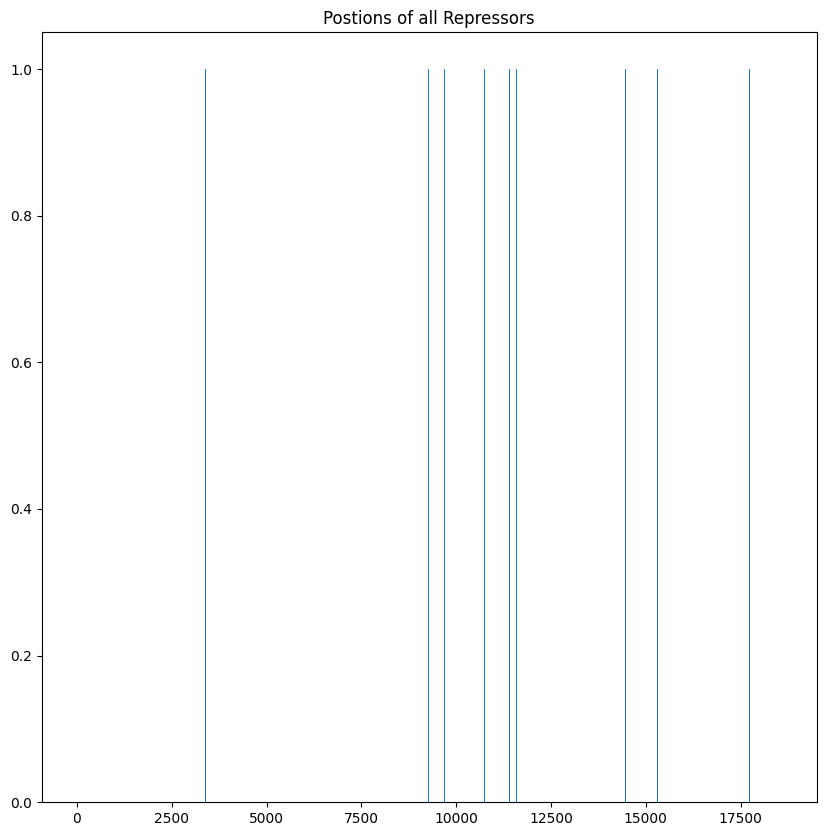

In [98]:

# plot locations of activators

BP_matrix = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/BP_Matrix.csv', index_col=0)

column_means = BP_matrix.mean()

sign_dict = column_means.apply(lambda x: 1 if x >= 0 else -1 if x < 0 else 0).to_dict()

repressor_list = []

for key, value in sign_dict.items():
    if value == -1:
        repressor_list.append(key)

# exists = (A_matrix_edgelist['source'].isin(repressor_list))

# matching_rows = A_matrix_edgelist[exists]

# unique_values = pd.unique(matching_rows[['source', 'target']].values.ravel())

count = 0
positions = []
for x in flat_col_order:
    if x in repressor_list:
        count += 1
        positions.append(1)
    else:
        positions.append(0)
print(count)
print(len(positions))

indices = list(range(len(positions)))

plt.figure(figsize=(10, 10))
plt.bar(np.arange(len(positions)), positions)
plt.title('Postions of all Repressors')
plt.show()

18581
18581


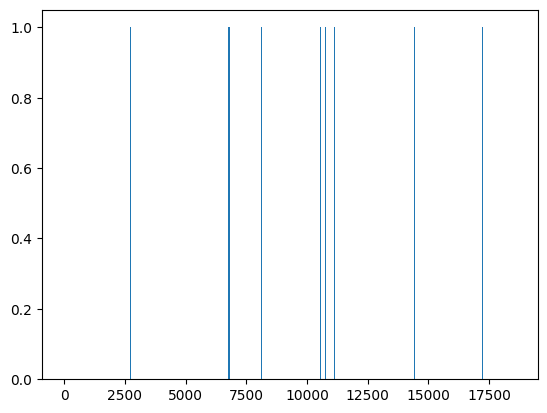

Text(0.5, 1.0, 'Positions where TF binds to')

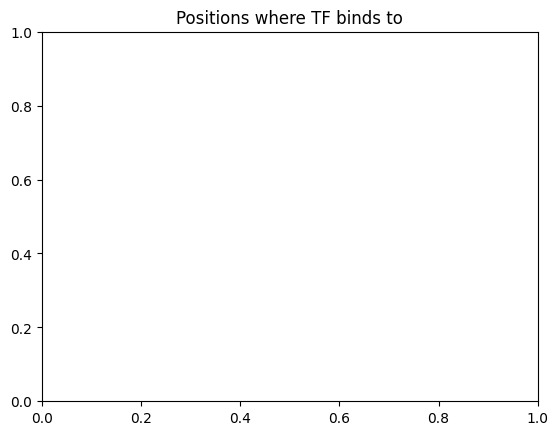

In [ ]:

# Plot where a specific transcription factor binds

myod_list = ['ENSG00000129152']

exists = (A_matrix_edgelist['source'] == 'ENSG00000129152') | (A_matrix_edgelist['target'] == 'ENSG00000129152')

# Get matching rows
matching_rows = A_matrix_edgelist[exists]


unique_values = pd.unique(matching_rows[['source', 'target']].values.ravel())

positions = []
for x in flat_col_order:
    if x in unique_values:
        positions.append(1)
    else:
        positions.append(0)
print(len(positions))
print(len(flat_col_order))

indices = list(range(len(positions)))

plt.figure(figsize=(10,10))
plt.bar(np.arange(len(positions)), positions)
plt.title("Positions where TF binds to")
plt.show()



# myod_exists = A_matrix_edgelist[
#     A_matrix_edgelist['source'].isin(myod_list) & A_matrix_edgelist['target'].isin(myod_list)
# ]



In [213]:

c_matrix = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/C_Matrix_edgelist.csv')

master_regulators = c_matrix[c_matrix['source'] == c_matrix['target']]

master_regulator_list = list(c_matrix['source'])

transcription_factor_matx = c_matrix[c_matrix['source'] != c_matrix['target']]

transcription_factor_list = pd.unique(transcription_factor_matx[['source', 'target']].values.ravel())

BP_matrix = pd.read_csv('/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/BP_Matrix.csv', index_col=0)

column_means = BP_matrix.mean()

sign_dict = column_means.apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0).to_dict()

ENSEMBL_GENE_NAME_PATH = "/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/ENSEMBL/Gene Names.tsv"

ensembl_df = pd.read_csv(ENSEMBL_GENE_NAME_PATH, sep='\t')

gene_id_name_map = dict(zip(ensembl_df['Gene stable ID'], ensembl_df['Gene name']))

# POU5F1, SOX2, KLF4, MYC
gene_id_name_map.update(dict(zip( ['ENSG00000134323', 'ENSG00000111704', 'ENSG00000204531', 'ENSG00000129152', 'ENSG00000136826', 'ENSG00000136997', 'ENSG00000181449', 'ENSG00000122180'], ['MYCN', 'NANOG' ,'POU5F1', 'MYOD1', 'KLF4', 'MYC', 'SOX2', 'MYOG'])))

# gene_id_name_map

def get_piece_network(edgelist, full_edgelist, start_index, end_index, order, perturbed_edges=[]):

    global sign_dict

    list_chunk = order[start_index:end_index]

    normal_edges = []
    activator_edges = []
    repressor_edges = []
    for edge in perturbed_edges:
        sign = sign_dict.get(edge, 0)
        if sign == -1:
            repressor_edges.append(edge)
        elif sign == 1:
            activator_edges.append(edge)
        else:
            normal_edges.append(edge)


    # get only the activators from the full edgelist

    ts_perturbed_edgelist = full_edgelist[
            full_edgelist['source'].isin(activator_edges) & full_edgelist['target'].isin(list_chunk)
    ]

    st_perturbed_edgelist = full_edgelist[
            full_edgelist['source'].isin(list_chunk) & full_edgelist['target'].isin(activator_edges)
    ]

    perturbed_edgelist = pd.concat([ts_perturbed_edgelist, st_perturbed_edgelist], ignore_index=True)


    filtered_edgelist = edgelist[
            edgelist['source'].isin(list_chunk) & edgelist['target'].isin(list_chunk)
    ]

    concat_df = pd.concat([perturbed_edgelist, filtered_edgelist], ignore_index=True)

    return concat_df, list_chunk + perturbed_edges, normal_edges, activator_edges, repressor_edges

/var/folders/bw/k47pyks15hj5krd7g8r02s_c0000gn/T/ipykernel_32501/1247080974.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ensembl_df = pd.read_csv(ENSEMBL_GENE_NAME_PATH, sep='\t')


In [218]:


def construct_graph(filtered_edgelist, filtered_nodes, perturbed_edges, normal_edges, activator_edges, repressor_edges, node_attrs, time_based=False, move_list=[]):
    global BP_matrix
    global transcription_factor_list
    global master_regulator_list
    global gene_id_name_map
    column_means = BP_matrix.mean()

    sign_dict = column_means.apply(lambda x: 1 if x >= 0 else -1 if x < 0 else 0).to_dict()


    highlight_color = "#a345f0"
    repressor_color = "#d77132"
    initiator_color = "#f83e56"

    # g1_color = '#0096c7'
    # g2_color = '#00b4d8'
    # g3_color = "#90e0ef"
    g1_color = "#6b7fa6"
    g2_color = "#86c9d7"
    g3_color = "#c6d6d8"
    filtered_graph = nx.from_pandas_edgelist(filtered_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())
    filtered_graph.add_nodes_from(filtered_nodes)
    filtered_graph.add_nodes_from(activator_edges)
    filtered_graph.add_nodes_from(repressor_edges)
    filtered_graph.add_nodes_from(move_list)



    # filtered_graph = connect_unconnected_nodes(filtered_graph)


    centrality = nx.degree_centrality(filtered_graph)
    cent_values = np.array(list(centrality.values()))
    cent_min, cent_max = cent_values.min(), cent_values.max()
    norm_centrality = {node: (val - cent_min) / (cent_max - cent_min) for node, val in centrality.items()}

    # Use a colormap (e.g., 'viridis') to map centrality → color
    # cmap = cm.get_cmap('winter')
    cmap = custom_cmap
    node_colors = {node: cmap(norm_centrality[node]) for node in filtered_graph.nodes()}

    degree_centrality = nx.degree_centrality(filtered_graph)


    # for dynamic graphs
    timepoints = len(perturbed_edges) + 1

    for node in node_attrs:
        key = node['key']
        nat = node['attributes']
        x = nat['x']
        y = nat['y']
        if key in filtered_graph:
            # degree = degree_centrality[key]
            degree = filtered_graph.degree[key]
            filtered_graph.nodes[key]['size'] = 15 + 1 * degree

            if abs(x) > 3000 or abs(y) > 3000:
                filtered_graph.nodes[key]['x'] = 0
                filtered_graph.nodes[key]['y'] = 0

            filtered_graph.nodes[key]['x'] = x
            filtered_graph.nodes[key]['y'] = y
            if time_based:
                filtered_graph.nodes[key]['color_dynamic'] = f"<[{0},{timepoints}{'#%02x%02x%02x' % tuple(int(255 * c) for c in node_colors[key][:3])}]>"
                filtered_graph.nodes[key]['perturbed_dynamic'] = f"<[{0},{timepoints}{'#%02x%02x%02x' % tuple(int(255 * c) for c in node_colors[key][:3])}]>"
                filtered_graph.nodes[key]['color'] = '#%02x%02x%02x' % tuple(int(255 * c) for c in node_colors[key][:3])
            else:
                filtered_graph.nodes[key]['color'] = '#%02x%02x%02x' % tuple(int(255 * c) for c in node_colors[key][:3])

            if key in master_regulator_list:
                filtered_graph.nodes[key]['color'] = g1_color
            elif key in transcription_factor_list:
                filtered_graph.nodes[key]['color'] = g2_color
            else:
                filtered_graph.nodes[key]['color'] = g3_color



            filtered_graph.nodes[key]['genename'] = gene_id_name_map.get(key, "NA")
            filtered_graph.nodes[key]['start'] = 0
            filtered_graph.nodes[key]['end'] = timepoints + 10
            filtered_graph.nodes[key]['level'] = 1

            filtered_graph.nodes[key]['interval'] = f"<[{0},{timepoints + 10}]>"

            if not(filtered_graph.nodes[key].get('perturbed')):
                filtered_graph.nodes[key]['perturbed'] = False


    splits = 10
    if timepoints > splits:
        partitions = timepoints // splits
    else:
        partitions = 2
    count = 0
    for key in perturbed_edges:
        if key in filtered_graph:
            if key in normal_edges:
                filtered_graph.nodes[key]['color'] = highlight_color
                filtered_graph.nodes[key]['level'] = 2
            elif key in activator_edges:
                filtered_graph.nodes[key]['color'] = highlight_color
                filtered_graph.nodes[key]['level'] = 3
            else:
                filtered_graph.nodes[key]['color'] = repressor_color
                filtered_graph.nodes[key]['level'] = 4

            
            if time_based and not(filtered_graph.nodes[key].get('perturbed')):
                filtered_graph.nodes[key]['color_dynamic'] = f"<[{0},{count},{'#%02x%02x%02x' % tuple(int(255 * c) for c in node_colors[key][:3])}],[{count}, {timepoints},{highlight_color}]>"
                filtered_graph.nodes[key]['perturbed_dynamic'] = f"<[{0},{count},{'#%02x%02x%02x' % tuple(int(255 * c) for c in node_colors[key][:3])}],[{count}, {timepoints},{highlight_color}]>"
                filtered_graph.nodes[key]['color'] = highlight_color
            else:
                if sign_dict.get(key) == 1:
                    filtered_graph.nodes[key]['color'] = highlight_color
                else:
                    filtered_graph.nodes[key]['color'] = repressor_color

            if not(filtered_graph.nodes[key].get('perturbed')):
                filtered_graph.nodes[key]['perturbed'] = True

        count += 1

    ncount = 0
    for nn in move_list:
        if nn in filtered_graph:
            filtered_graph.nodes[nn]['x'] = 2000 + (ncount * 10)
            filtered_graph.nodes[nn]['y'] = 2000 + (ncount * 10)
            if nn in filtered_graph:
                filtered_graph.nodes[nn]['color'] = initiator_color
            
            filtered_graph.nodes[nn]['size'] = max(filtered_graph.nodes[nn].get('size', 0), 50)

            if not(filtered_graph.nodes[nn].get('perturbed')):
                filtered_graph.nodes[nn]['perturbed'] = True

        ncount += 1

        # if count % partitions == 0:
        #     nx.write_graphml(filtered_graph, f"{savepath}/final_graphs/combination_perturbed_third_order_time_based_tp_{count}.graphml")


    return filtered_graph

In [195]:
import networkx as nx
import json

def export_graph_as_json(G, file_path):
    ll = [ ]
    for n in G.nodes():
        nodeattrs = G.nodes[n]
        genename = str(nodeattrs.get('genename', "NA"))
        if 'genename' in nodeattrs:
            del nodeattrs['genename']
        if genename == "NA" or None:
            genename = str(n)
        ll.append({"data": {"id": str(n), "genename": genename, **nodeattrs}})

    # Convert to Cytoscape.js format
    cy_data = {
        "nodes": ll,
        "edges": [
            {"data": {"id": f"{u}-{v}", "source": str(u), "target": str(v), **G.edges[u, v]}} for u, v in G.edges()
        ]
    }

    # Save to JSON
    with open(file_path, "w") as f:
        json.dump(cy_data, f, indent=2)


In [207]:
celltype = 'all_cells'
current_edgelist = A_matrix_edgelist
savepath = f'/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/combinations/{celltype}'

start_index = 14500
end_index = 15500

perturbed_edges=[]
node_attrs=[]
move_list = []

# filtered_edgelist, filtered_nodes = get_piece_network(current_edgelist, A_matrix_edgelist, start_index, end_index, flat_col_order, perturbed_edges)
filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges = get_piece_network(current_edgelist, A_matrix_edgelist, start_index, end_index, flat_col_order, perturbed_edges)
filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges, perturbed_edges, node_attrs, time_based=False, move_list=move_list)

nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_second_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

In [219]:


import matplotlib.cm as cm







# celltype = 'fibroblast'
# celltype = 'myotube'
celltype = 'esc'
# celltype = 'all_cells'
# current_edgelist = A_matrix_edgelist
# current_edgelist = fibroblast_filtered_edgelist
# current_edgelist = myotube_filtered_edgelist
current_edgelist = esc_filtered_edgelist

savepath = f'/Users/ramprakash/development/lab_projects/Rajapakse_lab/data/HWG/HWG/combinations/{celltype}'

start_index = 13500
end_index = 14500
time_based = False

import json
# with open('/Users/ramprakash/development/lab_projects/Rajapakse_lab/projects/HardWiredGenome/graphs/connected_A_matrix.json') as f:
# with open(f'/Users/ramprakash/development/lab_projects/Rajapakse_lab/projects/HardWiredGenome/graphs/combination_perturbed_150_all_cells_{start_index}_{end_index}.json') as f:
with open(f'/Users/ramprakash/development/lab_projects/Rajapakse_lab/projects/HardWiredGenome/graphs/combination_perturbed_150_all_cells_{9000}_{11000}.json') as f:
    data = json.load(f)
node_attrs = data['nodes']

# ENSG00000129152 - MYOD1
# perturbed_edges = ['ENSG00000129152', 'ENSG00000122180']
# move_list = ['ENSG00000129152', 'ENSG00000122180']

# mycn, nanog ,pou5f1
perturbed_edges = ['ENSG00000134323', 'ENSG00000111704', 'ENSG00000204531']
move_list = ['ENSG00000134323', 'ENSG00000111704', 'ENSG00000204531']

# yamanaka factors
# oct4 - POU5F1
# POU5F1, SOX2, KLF4, MYC
# ['POU5F1',  'KLF4', 'MYC', 'SOX2']
# move_list =  ['ENSG00000204531',  'ENSG00000136826', 'ENSG00000136997', 'ENSG00000181449']



graph_json_path = '/Users/ramprakash/development/lab_projects/Rajapakse_lab/projects/HardWiredGenome/visualization/data/'

# perturbed_edges = []

# first order interactions

filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges = get_piece_network(current_edgelist, A_matrix_edgelist, start_index, end_index, flat_col_order, perturbed_edges)


# filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, perturbed_edges, node_attrs)
# # nx.write_gexf(filtered_graph, f"{savepath}/combination_connected_{threshold}_{celltype}_start_end_{start_index}_{end_index}.gexf")
# nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_first_order_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges, perturbed_edges, node_attrs, time_based=time_based, move_list=move_list)
# nx.write_gexf(filtered_graph, f"{savepath}/combination_connected_{threshold}_{celltype}_start_end_{start_index}_{end_index}.gexf")
nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_first_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

export_graph_as_json(filtered_graph, f"{graph_json_path}/combination_perturbed_first_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.json")

# second order interactions

exists = (filtered_edgelist['source'].isin(perturbed_edges) | (filtered_edgelist['target'].isin(perturbed_edges)))

matching_rows = filtered_edgelist[exists]
perturbed_edges = list(pd.unique(matching_rows[['source', 'target']].values.ravel()))
print(len(perturbed_edges), perturbed_edges)

filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges = get_piece_network(current_edgelist, A_matrix_edgelist, start_index, end_index, flat_col_order, perturbed_edges)

# filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, perturbed_edges, node_attrs)
# nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_second_order_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges, perturbed_edges, node_attrs, time_based=time_based, move_list=move_list)
nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_second_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

export_graph_as_json(filtered_graph, f"{graph_json_path}/combination_perturbed_second_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.json")

#third order interactions
exists = (filtered_edgelist['source'].isin(perturbed_edges) | (filtered_edgelist['target'].isin(perturbed_edges)))

matching_rows = filtered_edgelist[exists]
perturbed_edges = list(pd.unique(matching_rows[['source', 'target']].values.ravel()))
print(len(perturbed_edges), perturbed_edges)

filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges = get_piece_network(current_edgelist, A_matrix_edgelist, start_index, end_index, flat_col_order, perturbed_edges)

# filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, perturbed_edges, node_attrs)
# nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_third_order_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

filtered_graph = construct_graph(filtered_edgelist, filtered_nodes, normal_edges, activator_edges, repressor_edges, perturbed_edges, node_attrs, time_based=time_based, move_list=move_list)
nx.write_graphml(filtered_graph, f"{savepath}/combination_perturbed_third_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.graphml")

export_graph_as_json(filtered_graph, f"{graph_json_path}/combination_perturbed_third_order_time_based_{threshold}_{celltype}_start_end_{start_index}_{end_index}.json")

# import pandas as pd

# node_data = [
#     {"Id": node, "x": data.get("x", 0), "y": data.get("y", 0)}
#     for node, data in filtered_graph.nodes(data=True)
# ]

# pd.DataFrame(node_data).to_csv(f"{savepath}/combination_perturbed_node_info_{threshold}_{celltype}_start_end_{start_index}_{end_index}.csv", index=False)


# edgelist_df = nx.to_pandas_edgelist(filtered_graph)

# edgelist_df.to_csv(f"{savepath}/combination_connected_{threshold}_{celltype}_start_end_{start_index}_{end_index}.csv", index=False)



21 ['ENSG00000134323', 'ENSG00000179361', 'ENSG00000205250', 'ENSG00000102996', 'ENSG00000005339', 'ENSG00000102882', 'ENSG00000167526', 'ENSG00000102974', 'ENSG00000182054', 'ENSG00000187555', 'ENSG00000118900', 'ENSG00000166851', 'ENSG00000169032', 'ENSG00000179776', 'ENSG00000103449', 'ENSG00000087263', 'ENSG00000103034', 'ENSG00000103479', 'ENSG00000039068', 'ENSG00000103197', 'ENSG00000103266']
247 ['ENSG00000005339', 'ENSG00000166164', 'ENSG00000134323', 'ENSG00000179361', 'ENSG00000039068', 'ENSG00000140992', 'ENSG00000102978', 'ENSG00000169018', 'ENSG00000205250', 'ENSG00000103197', 'ENSG00000186260', 'ENSG00000167978', 'ENSG00000103266', 'ENSG00000102996', 'ENSG00000255302', 'ENSG00000185338', 'ENSG00000102882', 'ENSG00000149922', 'ENSG00000167526', 'ENSG00000102974', 'ENSG00000099364', 'ENSG00000182054', 'ENSG00000172183', 'ENSG00000169926', 'ENSG00000162104', 'ENSG00000140968', 'ENSG00000103275', 'ENSG00000067955', 'ENSG00000187555', 'ENSG00000118900', 'ENSG00000179583', 'EN

In [ ]:
flat_gene_list

In [273]:
from constants import HUMAN_TF_SET_PATH
def get_TF_set():
    TF_set = set()
    with open(HUMAN_TF_SET_PATH, "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            gene, istf = line.strip().split(',')
            if bool(istf):
                TF_set.add(gene)

    print(f"Total TFs: {len(TF_set)}")
    return TF_set


tf_set = get_TF_set()
tflist = list(tf_set)

Total TFs: 2765


In [284]:


B_matrix_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(flat_col_order) & A_matrix_edgelist['target'].isin(tflist)
]

HARD_WIRED_GENOME_B_EDGELIST = f"{DATA_DIRECTORY}/HWG/B_Matrix_edgelist.csv"
path = HARD_WIRED_GENOME_B_EDGELIST

# df = pd.read_csv(path, index_col=0)
B_matrix_edgelist.to_csv(path, index=False)

B_matrix_edgelist = pd.read_csv(path)

In [285]:
b_graph = nx.from_pandas_edgelist(B_matrix_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())
b_graph.add_nodes_from(flat_col_order)

b_adjacency = nx.to_pandas_adjacency(b_graph)

# b_adjacency.head

In [ ]:

from constants import HARD_WIRED_GENOME_B_MATRIX_PATH

existing_tflist = [gene for gene in tflist if gene in b_adjacency.columns]
b_adjacency[existing_tflist].to_csv(HARD_WIRED_GENOME_B_MATRIX_PATH)

HARD_WIRED_GENOME_C_MATRIX_PATH = f"{DATA_DIRECTORY}/HWG/C_Matrix.csv"

c_matrix = b_adjacency.loc[existing_tflist, existing_tflist]
c_matrix.to_csv(HARD_WIRED_GENOME_C_MATRIX_PATH)


In [294]:

HARD_WIRED_GENOME_B_EDGELIST = f"{DATA_DIRECTORY}/HWG/B_Matrix_edgelist.csv"
HARD_WIRED_GENOME_C_EDGELIST = f"{DATA_DIRECTORY}/HWG/C_Matrix_edgelist.csv"

B_matrix_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(flat_col_order) & A_matrix_edgelist['target'].isin(tflist)
]

C_matrix_edgelist = A_matrix_edgelist[
    A_matrix_edgelist['source'].isin(tflist) & A_matrix_edgelist['target'].isin(tflist)
]


B_matrix_edgelist.to_csv(HARD_WIRED_GENOME_B_EDGELIST, index=False)
C_matrix_edgelist.to_csv(HARD_WIRED_GENOME_C_EDGELIST, index=False)

In [ ]:
start_index = 0
end_index = 1000


filtered_edgelist, filtered_nodes = get_piece_network(C_matrix_edgelist, A_matrix_edgelist, start_index, end_index, tflist)

filtered_graph = nx.from_pandas_edgelist(filtered_edgelist, 'source', 'target', edge_attr='weight', create_using=nx.Graph())
filtered_graph.add_nodes_from(filtered_nodes)

nx.write_graphml(filtered_graph, f"{DATA_DIRECTORY}/HWG/C_matrix_network_{start_index}_{end_index}.graphml")

['ENSG00000170004', 'ENSG00000116731', 'ENSG00000104064', 'ENSG00000104856', 'ENSG00000162761', 'ENSG00000122180', 'ENSG00000163220', 'ENSG00000123405', 'ENSG00000132170', 'ENSG00000171855', 'ENSG00000158545', 'ENSG00000080503', 'ENSG00000178764', 'ENSG00000260027', 'ENSG00000083812', 'ENSG00000106459', 'ENSG00000101076', 'ENSG00000137834', 'ENSG00000197170', 'ENSG00000120659', 'ENSG00000130700', 'ENSG00000133703', 'ENSG00000198807', 'ENSG00000173917', 'ENSG00000068024', 'ENSG00000152795', 'ENSG00000136574', 'ENSG00000111087', 'ENSG00000188171', 'ENSG00000198342', 'ENSG00000163508', 'ENSG00000143437', 'ENSG00000138795', 'ENSG00000198791', 'ENSG00000135870', 'ENSG00000147604', 'ENSG00000156853', 'ENSG00000140968', 'ENSG00000198353', 'ENSG00000204209', 'ENSG00000183421', 'ENSG00000110713', 'ENSG00000140396', 'ENSG00000185730', 'ENSG00000059145', 'ENSG00000171316', 'ENSG00000156574', 'ENSG00000100324', 'ENSG00000169564', 'ENSG00000135341', 'ENSG00000125347', 'ENSG00000143799', 'ENSG000001

array(['ENSG00000170004', 'ENSG00000116731', 'ENSG00000104064', ...,
       'ENSG00000109339', 'ENSG00000240747', 'ENSG00000064489'],
      shape=(2621,), dtype=object)

['ENSG00000170004' 'ENSG00000116731' 'ENSG00000104064' ...
 'ENSG00000109339' 'ENSG00000240747' 'ENSG00000064489']


In [91]:
len(list(set(repressor_list)))

215